In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../Code/')
sys.path.append('../')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from RNN_tools import get_model, keras2casadi
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_labels = pd.read_json('150sim_cluster_labels.json')
pressure_factor = pd.read_json('150sim_pressure_factor.json')
n_clusters = 30

Get results:

In [6]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_10_try.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [7]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [8]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


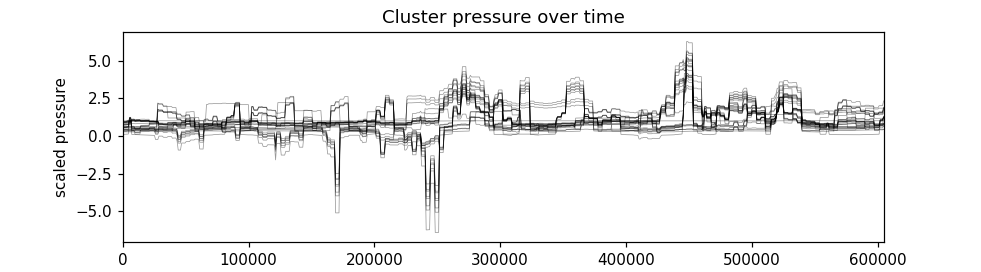

In [9]:
fig, ax = plt.subplots(figsize=(9,2.5))
jun_cl_press_mean.plot(ax=ax, legend=False, linewidth=0.5, color='k', alpha=0.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('scaled pressure')
ax.set_title('Cluster pressure over time')
plt.show()

### Tanks

In [10]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


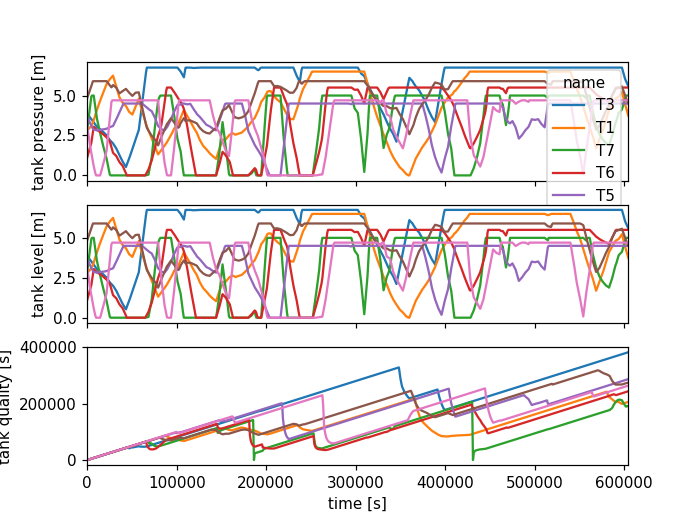

Text(0.5, 0, 'time [s]')

In [11]:
fig, ax = plt.subplots(3,1, sharex=True,)
tank_press.plot(ax=ax[0])
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
tank_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('tank quality [s]')
ax[2].set_xlabel('time [s]')

### Reservoirs

In [12]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


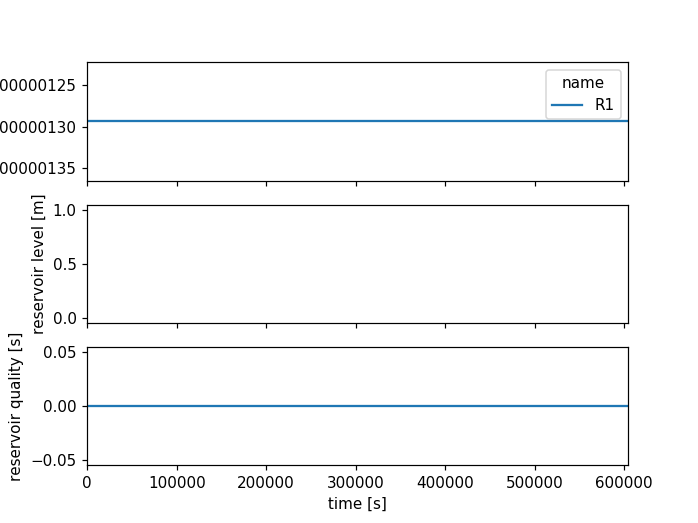

Text(0.5, 0, 'time [s]')

In [13]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [14]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

<IPython.core.display.Javascript object>


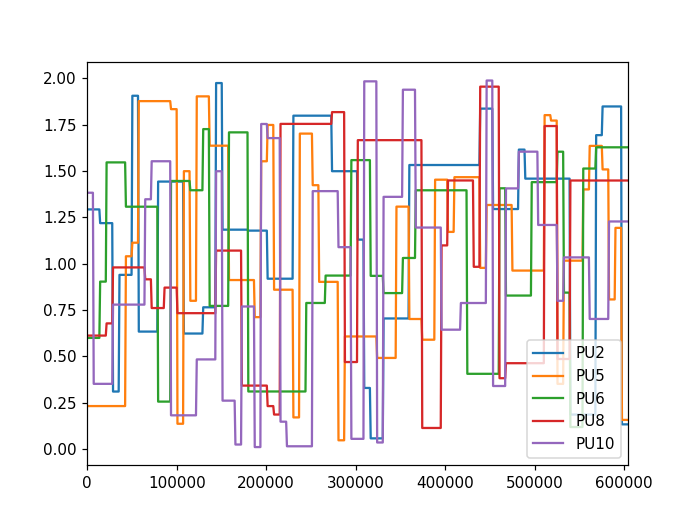

In [15]:
fig, ax = plt.subplots()
head_pump_speed.plot(ax=ax)

In [16]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,118.807031,0.0,0.0,0.0,40.410190
900,118.911016,0.0,0.0,0.0,40.524191
1800,119.014632,0.0,0.0,0.0,40.637595


<IPython.core.display.Javascript object>


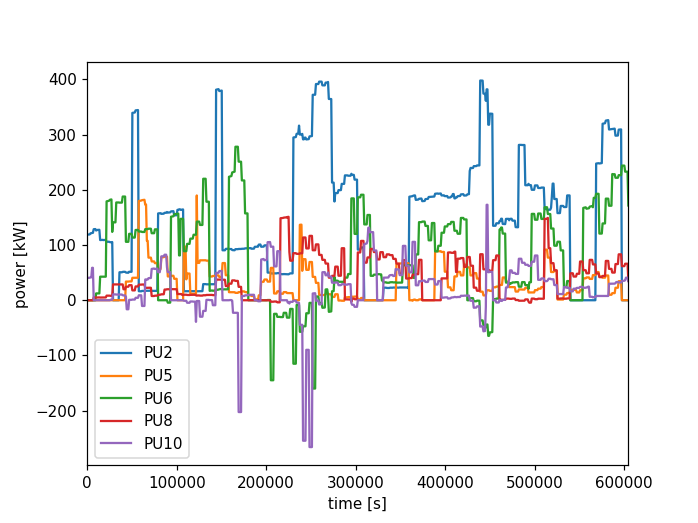

Text(0.5, 0, 'time [s]')

In [17]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [18]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


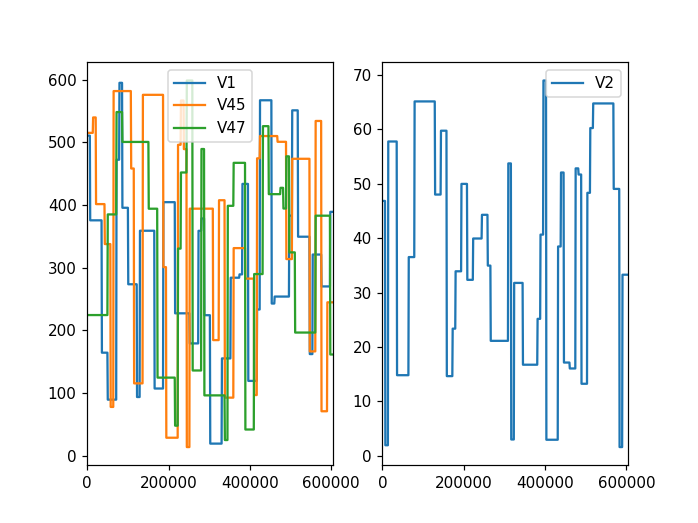

In [19]:
fig, ax = plt.subplots(1,2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [20]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [21]:
dsys_states = sys_states.diff(axis=0)

sys_states_next = sys_states.shift(-1, axis=0)
dsys_states_next = dsys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': sys_states_next,
                 #'dsys_states_next' : dsys_states_next,
                 'aux_outputs': aux_outputs}


nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [22]:
nn_output.head(3)

sys_states                                                    \
     jun_cl_press_mean                                                     
                     0         1         2         3         4         5   
0             0.274082  0.916862  0.967908  0.953012  0.902942  0.330536   
900           0.271634  0.917873  0.968971  0.953921  0.904281  0.328307   
1800          0.269186  0.918886  0.970036  0.954831  0.905622  0.326077   

                                              ...                       \
                                              ... tank_press             
             6         7         8         9  ...         T7        T6   
0     0.901740  0.568235  0.906140  0.574642  ...   3.290652  1.310897   
900   0.902891  0.571593  0.907574  0.578001  ...   3.689335  1.488728   
1800  0.904045  0.574940  0.909010  0.581347  ...   4.086538  1.667024   

                                   aux_outputs                            
                                   pump_energy                            
            T5        T2        T4         PU2  PU5  PU6  PU8       PU10  
0     3.549446  5.004117  2.728034  118.807031  0.0  0.0  0.0  40.410190  
900   3.438960  5.148332  2.384743  118.911016  0.0  0.0  0.0  40.524191  
1800  3.328465  5.291826  2.041462  119.014632  0.0  0.0  0.0  40.637595  

[3 rows x 42 columns]

Inputs of the neural network:

In [23]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 76)


In [24]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (672, 76)


In [25]:
print(nn_input.isnull().any().any())
print(nn_output.isnull().any().any())

False
False


### Normalize Data:

In [26]:
input_offset = nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

input_offset = input_offset.to_numpy().reshape(1,-1)
input_scaling = input_scaling.to_numpy().reshape(1,-1)
output_offset = output_offset.to_numpy().reshape(1,-1)
output_scaling = output_scaling.to_numpy().reshape(1,-1)

### Train/Test split:

In [27]:
tt_split = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2, shuffle=False)
X_train, X_test, Y_train, Y_test = [arr.to_numpy() for arr in tt_split]

## RNN I/O structure

In [28]:
seq_length = 20  # length of sequence for ANN training

# create sequences from the data:
X = []
Y = []

n_data = X_train.shape[0]
n_seq = n_data // seq_length - 1


for data_sample in range(n_seq):
    start_ind = data_sample*seq_length
    X.append(X_train[start_ind:start_ind + seq_length, :])
    Y.append(Y_train[start_ind:start_ind + seq_length, :])
    
X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

In [29]:
X.shape

(25, 20, 76)

In [30]:
# If batch_size > 1 and stateful mode active, the order of the elements has to be adapted.
batch_size = 5
n_batches = X.shape[0]//batch_size
n_data_red = batch_size*n_batches
batch_ind = np.arange(n_data_red).reshape(-1, n_batches).T.ravel()

X = X[batch_ind, :, :]
Y = Y[batch_ind, :, :]

nx = X.shape[2]
ny = Y.shape[2]

# Create RNN

In [50]:
stateful = True
n_layer = 2  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [40]
model_param['p_dropout'] = None  # Placeholder. Not yet used.
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 40
model_param['RNN_param']['recurrent_dropout'] = 0
model_param['RNN_param']['dropout'] = 0.
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.summary()

No value selected for dropout, choosing do=0.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (40, 20, 40)              18720     
_________________________________________________________________
time_distributed_3 (TimeDist (40, 20, 40)              1640      
_________________________________________________________________
dropout_2 (Dropout)          (40, 20, 40)              0         
_________________________________________________________________
time_distributed_4 (TimeDist (40, 20, 40)              1640      
_________________________________________________________________
dropout_3 (Dropout)          (40, 20, 40)              0         
_________________________________________________________________
time_distributed_5 (TimeDist (40, 20, 42)              1722      
Total params: 23,722
Trainable params: 23,722
Non-trainable params: 0
____

In [52]:
model.compile(loss='mse', optimizer='Adam')
if stateful:
    cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())
else:
    cb_reset = keras.callbacks.LambdaCallback()

cb_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6, patience=10, mode='min')
model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=50, verbose=1, shuffle=not(stateful))

Train on 1280 samples
Epoch 1/50
1280/1280 [==============================] - 4s 3ms/sample - loss: 0.0022
Epoch 2/50
1280/1280 [==============================] - 1s 682us/sample - loss: 0.0021
Epoch 3/50
1280/1280 [==============================] - 1s 666us/sample - loss: 0.0021
Epoch 4/50
1280/1280 [==============================] - 1s 726us/sample - loss: 0.0021
Epoch 5/50
1280/1280 [==============================] - 1s 540us/sample - loss: 0.0021
Epoch 6/50
1280/1280 [==============================] - 1s 684us/sample - loss: 0.0021
Epoch 7/50
1280/1280 [==============================] - 1s 737us/sample - loss: 0.0021
Epoch 8/50
1280/1280 [==============================] - 1s 707us/sample - loss: 0.0021
Epoch 9/50
1280/1280 [==============================] - 1s 853us/sample - loss: 0.0021
Epoch 10/50
1280/1280 [==============================] - 1s 740us/sample - loss: 0.0021
Epoch 11/50
1280/1280 [==============================] - 1s 725us/sample - loss: 0.0020
Epoch 12/50
1280/1280

# Evaluate Model

In [53]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

No value selected for dropout, choosing do=0.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 1, 40)                18720     
_________________________________________________________________
time_distributed_6 (TimeDist (1, 1, 40)                1640      
_________________________________________________________________
dropout_4 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_7 (TimeDist (1, 1, 40)                1640      
_________________________________________________________________
dropout_5 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_8 (TimeDist (1, 1, 42)                1722      
Total params: 23,722
Trainable params: 23,722
Non-trainable params: 0
____

Initialize hidden state:

In [54]:
model_simple.reset_states()
# Initialize hidden state:
t = 0
dt = 900
for i,in_i in nn_input.iloc[:seq_length].iterrows():
    rnn_in_i = in_i.to_numpy().reshape(1,-1)
    rnn_in_scaled = (rnn_in_i - input_offset)/input_scaling
    model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    t += dt

In [55]:
x_arr = [sys_states.iloc[seq_length].to_numpy().reshape(1,-1)]
t_arr = [t]
for i,u_i in sys_inputs.iloc[seq_length:].iterrows():
    rnn_in_i = np.concatenate((x_arr[-1],u_i.to_numpy().reshape(1,-1)),axis=1)
    rnn_in_scaled = (rnn_in_i - input_offset)/input_scaling
    rnn_out_scaled = model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    rnn_out = rnn_out_scaled.squeeze()*output_scaling+output_offset
    t_arr.append(t_arr[-1]+dt)
    x_arr.append(rnn_out[[0],:37])
    
res = np.concatenate(x_arr)

In [56]:
res = pd.DataFrame(res, columns=sys_states.columns, index=t_arr)

In [115]:
res.head(3)

jun_cl_press_mean                                                    \
                      0         1         2         3         4         5   
18000          0.288023  0.987002  0.997753  1.007831  0.986111  0.411225   
18900         -1.143496  1.607691  2.380350  1.742187  2.025161 -0.738483   
19800         -0.772730  2.040777  2.931355  2.176330  2.719126 -0.457269   

                                               ...                      \
              6         7         8         9  ...        27        28   
18000  0.987418  0.487046  1.023103  0.514960  ...  0.420540  1.101444   
18900  1.689310  2.007579  1.829950  2.077831  ... -0.750335  1.841613   
19800  2.224212  2.695960  2.420406  2.630921  ... -0.361322  2.363945   

                tank_press                                                    \
             29         T3        T1        T7        T6        T5        T2   
18000  0.330936   2.712208  5.212750  1.799869  2.561853  2.882668  5.899998   
18900  0.611691   3.338456  4.369313  1.805281  3.892654  3.135035  5.433345   
19800  1.309696   3.570673  5.270639  1.934523  3.428847  3.539666  5.354589   

                 
             T4  
18000  0.726268  
18900  1.823705  
19800  3.085427  

[3 rows x 37 columns]

<IPython.core.display.Javascript object>


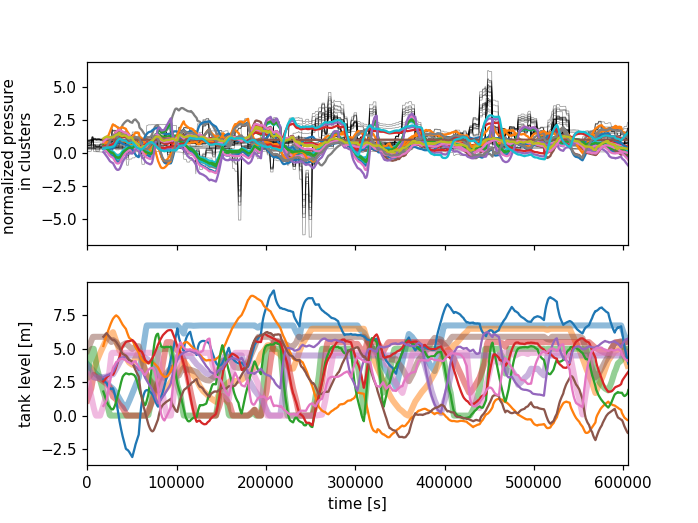

Text(0.5, 0, 'time [s]')

In [57]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
res['tank_press'].plot(ax=ax[1], legend=False)

ax[0].set_xlim(0, res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Keras 2 Casadi

In [39]:
from casadi import *

In [58]:
config = model_simple.get_config()
weights = model_simple.get_weights()

In [61]:
x_cas_in = MX.sym('x', 1, 76)
h_cas_in = MX.sym('h', 1, 40)
c_cas_in = MX.sym('c', 1, 40)

[x_cas_out, h_cas_out, c_cas_out], _ = keras2casadi(
    weights, config['layers'], [x_cas_in, h_cas_in, c_cas_in], backend_name='casadi')
fun = Function('fun', [x_cas_in, h_cas_in, c_cas_in], [x_cas_out, h_cas_out, c_cas_out])

In [84]:
x = np.ones((1, 76))
h = np.zeros((1, 40))
c = np.zeros((1, 40))

In [80]:
x = np.ones((1, 76))
x,h,c = fun(x,h,c)

In [81]:
x.full()

array([[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
         0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]])

In [77]:
model_simple.reset_states()

In [82]:
x = np.ones((1, 76))
model_simple.predict(x.reshape(1,1,-1))

array([[[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
          0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]]], dtype=float32)

# Create Full Training Dataset
Load data (lists of pandas objects)

In [38]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)[:40]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, cluster_labels, pressure_factor,
                                         narx_input=False, narx_output=False, return_lists=True)

Convert to list of numpy arrays:

In [39]:
nn_input_np_list = [i.to_numpy() for i in nn_input_list]
nn_output_np_list = [i.to_numpy() for i in nn_output_list]

Concatenate in time dimension:

In [40]:
nn_input_concat = np.concatenate(nn_input_np_list,axis =0)
nn_output_concat = np.concatenate(nn_output_np_list,axis =0)

Normalize data:

1.) Get factors:

In [41]:
input_offset = nn_input_concat.mean(axis=0, keepdims=True)
nn_input_offset = nn_input_concat - input_offset
input_scaling = np.max(np.abs(nn_input_offset),axis=0, keepdims=True)
input_scaling = np.maximum(input_scaling, 1e-5)

output_offset = nn_output_concat.mean(axis=0, keepdims=True)
nn_output_offset = nn_output_concat - output_offset
output_scaling = np.max(np.abs(nn_output_offset),axis=0, keepdims=True)
output_scaling =  np.maximum(output_scaling, 1e-5)

2.) Apply to list:

In [42]:
nn_input_np_list_norm = [(i-input_offset)/input_scaling for i in nn_input_np_list]
nn_output_np_list_norm = [(i-output_offset)/output_scaling for i in nn_output_np_list]

Stack lists:

In [43]:
nn_input_stacked = np.stack(nn_input_np_list_norm, axis=0)
nn_output_stacked = np.stack(nn_output_np_list_norm, axis=0)

In [48]:
seq_length = 20  # length of sequence for ANN training

# create sequences from the data:
X = []
Y = []

n_data = nn_input_stacked.shape[1]
n_seq = n_data // seq_length - 1



for data_sample in range(n_seq):
    start_ind = data_sample*seq_length
    X.append(nn_input_stacked[:,start_ind:start_ind + seq_length, :])
    Y.append(nn_output_stacked[:,start_ind:start_ind + seq_length, :])
    
X = np.concatenate(X, axis=0)  # [m, seq_length, nx]
Y = np.concatenate(Y, axis=0)  # [m, seq_length, ny]

In [49]:
batch_size=40
nx = X.shape[2]
ny = Y.shape[2]
X.shape

(1280, 20, 76)